<a href="https://colab.research.google.com/github/O-suke12/Semantic_Segmentation/blob/main/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from PIL import Image
import os
from google.colab import files

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Reference**





Dataset: https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset?sort=votes

# **Dataset**

In [ ]:
if os.path.exists("kaggle.json"):
  print("already exist")
else:
  uploaded = files.upload()
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle datasets download -d bulentsiyah/semantic-drone-dataset
  ! unzip  semantic-drone-dataset

Saving kaggle.json to kaggle.json
100% 3.89G/3.89G [03:25<00:00, 21.0MB/s]
100% 3.89G/3.89G [03:25<00:00, 20.3MB/s]
Archive:  semantic-drone-dataset.zip
  inflating: RGB_color_image_masks/RGB_color_image_masks/000.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/001.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/002.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/003.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/004.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/005.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/006.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/008.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/011.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/013.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/014.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/015.png  
  inflating: RGB_color_image_masks/RGB_colo

In [ ]:
df_class = pd.read_csv("/content/class_dict_seg.csv")
df_class.head()

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87


In [ ]:
import os
from sklearn.model_selection import train_test_split

dict = {"Name":[]}
df = pd.DataFrame(dict)
df = pd.DataFrame(os.listdir("/content/RGB_color_image_masks/RGB_color_image_masks"))
df_train, df_valid = train_test_split(df, test_size=0.1, random_state=42)
df_train, df_test = train_test_split(df_train, test_size=0.1, random_state=42)

In [ ]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from  torchvision import transforms
from torch.utils.data.dataloader import DataLoader

preprocess = transforms.Compose([
    transforms.Resize(size=(192, 224), antialias=False),
    transforms.ConvertImageDtype(torch.float),
 ])

class Custom_dataset(Dataset):
  def __init__(self, image_dir, mask_dir, df, transform=True):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    image = read_image(image_dir+"/"+self.df.iloc[idx,0][:-3]+"jpg")
    mask = read_image(mask_dir+"/"+self.df.iloc[idx,0])
    image = self.transform(image)
    mask = self.transform(mask)
    mask = torch.max(mask.permute(1, 2, 0),dim=2)[0]
    return image, mask

image_dir = "/content/dataset/semantic_drone_dataset/original_images"
mask_dir = "/content/RGB_color_image_masks/RGB_color_image_masks"

CD_train = Custom_dataset(image_dir, mask_dir, df_train, preprocess)
CD_valid = Custom_dataset(image_dir, mask_dir, df_valid, preprocess)
CD_test = Custom_dataset(image_dir, mask_dir, df_test, preprocess)
train_loader = DataLoader(CD_train, batch_size=16, shuffle=True, num_workers=2, drop_last=True)
valid_loader = DataLoader(CD_valid, batch_size=16, shuffle=True, num_workers=2, drop_last=True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


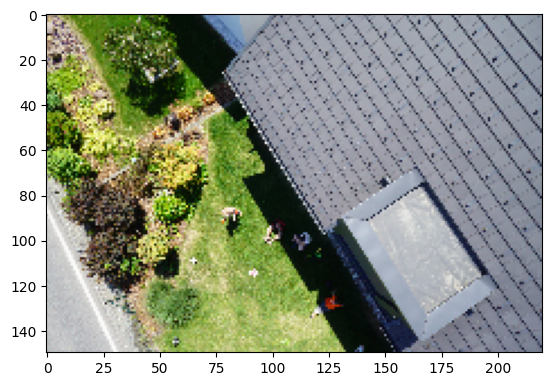

In [ ]:
import matplotlib.pyplot as plt
sample_image = CD_train.__getitem__(0)[0]

# sample_pred = model(sample_image.unsqueeze(0).to(torch.device(dev)))
# sample_pred = torch.tensor(sample_pred.cpu().squeeze(0))
plt.imshow(  sample_image.permute(1, 2, 0)  )
# plt.imshow(  sample_pred.permute(1, 2, 0))

# **Model**

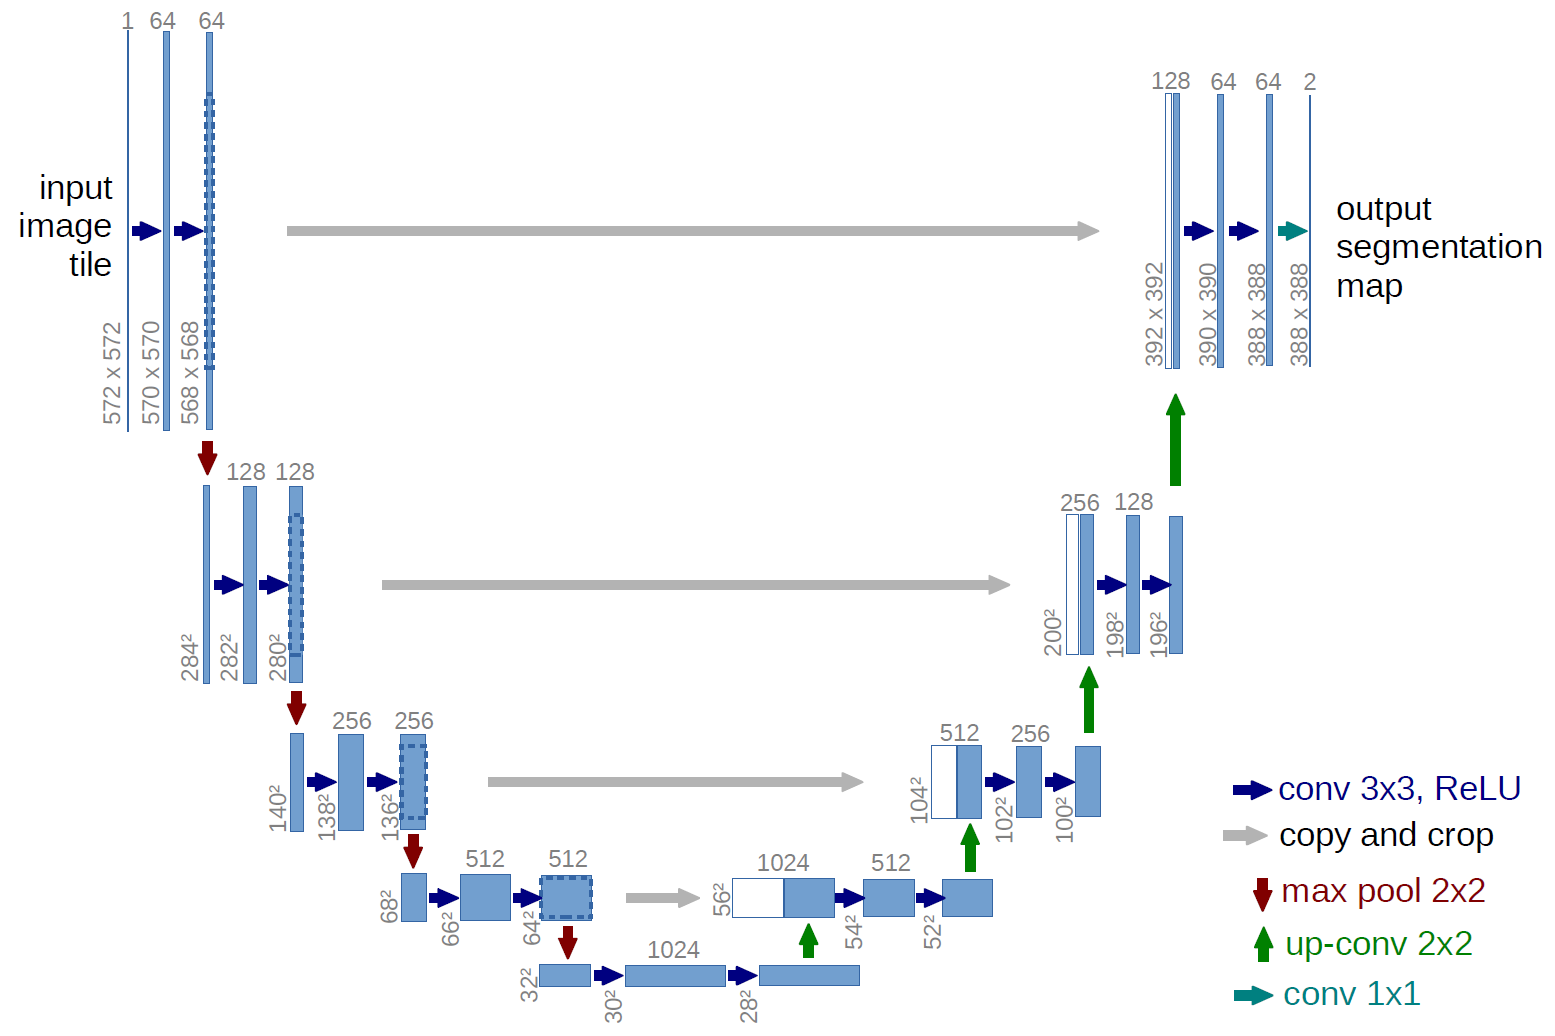![image.png](
  
)

In [ ]:
# from torchvision.transforms.functional import resize

# class double_conv(nn.Module):
#   def __init__(self, in_features, out_features):
#     super().__init__()
#     self.conv_block = nn.Sequential(
#         nn.Conv2d(in_features, out_features, 3, padding=1),
#         nn.BatchNorm2d(out_features),
#         nn.ReLU(inplace=True),
#         nn.Conv2d(out_features, out_features, 3, padding=1),
#         nn.BatchNorm2d(out_features),
#         nn.ReLU(inplace=True),
#     )
    
#   def forward(self,X):
#     return  self.conv_block(X)

# class UNET(nn.Module):
#   def __init__(self,):
#     super().__init__()
#     self.encode1 = nn.Sequential(
#         double_conv(3, 64),
#     )
#     self.encode2 = nn.Sequential(
#         nn.MaxPool2d(2,2),
#         double_conv(64, 128),
#     )
#     self.encode3 = nn.Sequential(
#         nn.MaxPool2d(2,2),
#         double_conv(128, 256),
#     )
#     self.encode4 = nn.Sequential(
#         nn.MaxPool2d(2,2),
#         double_conv(256, 512),
#     )
#     self.bottleneck = nn.Sequential(
#         nn.MaxPool2d(2,2),
#         double_conv(512, 1024),
#     )

#     self.decode1 = nn.Sequential(
#         nn.ConvTranspose2d(1024,512,2,2),
#     )

#     self.decode2 = nn.Sequential(
#         double_conv(1024, 512),
#         nn.ConvTranspose2d(512,256,2,2),
#     )

#     self.decode3 = nn.Sequential(
#         double_conv(512, 256),
#         nn.ConvTranspose2d(256,128,2,2),
#     )

#     self.decode4 = nn.Sequential(
#         double_conv(256,128),
#         nn.ConvTranspose2d(128,64,2,2),
#     )

#     self.last_conv = nn.Sequential(
#         double_conv(128,64),
#         nn.Conv2d(64,3,kernel_size=1)
#     )
  
#   def forward(self,X):
#     u1 = X = self.encode1(X)
#     u2 = X = self.encode2(X)
#     u3 = X = self.encode3(X)
#     u4 = X = self.encode4(X)

#     X = self.bottleneck(X)

#     X = self.decode1(X)
#     X = resize(X, u4.shape[2:])
#     X = self.decode2(torch.cat((u4,X),dim=1))
#     X = resize(X, u3.shape[2:])
#     X = self.decode3(torch.cat((u3,X),dim=1))
#     X = resize(X, u2.shape[2:])
#     X = self.decode4(torch.cat((u2,X),dim=1))
#     X = resize(X, u1.shape[2:])
#     return self.last_conv(torch.cat((u1,X),dim=1))


# model = UNET()
# model = model.to(torch.device(dev))

In [ ]:
class encoding_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(encoding_block,self).__init__()
        model = []
        model.append(nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        model.append(nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*model)
    def forward(self, x):
        return self.conv(x)   
    
class unet_model(nn.Module):
    def __init__(self,out_channels=23,features=[64, 128, 256, 512]):
        super(unet_model,self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv1 = encoding_block(3,features[0])
        self.conv2 = encoding_block(features[0],features[1])
        self.conv3 = encoding_block(features[1],features[2])
        self.conv4 = encoding_block(features[2],features[3])
        self.conv5 = encoding_block(features[3]*2,features[3])
        self.conv6 = encoding_block(features[3],features[2])
        self.conv7 = encoding_block(features[2],features[1])
        self.conv8 = encoding_block(features[1],features[0])        
        self.tconv1 = nn.ConvTranspose2d(features[-1]*2, features[-1], kernel_size=2, stride=2)
        self.tconv2 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
        self.tconv3 = nn.ConvTranspose2d(features[-2], features[-3], kernel_size=2, stride=2)
        self.tconv4 = nn.ConvTranspose2d(features[-3], features[-4], kernel_size=2, stride=2)        
        self.bottleneck = encoding_block(features[3],features[3]*2)
        self.final_layer = nn.Conv2d(features[0],out_channels,kernel_size=1)
    def forward(self,x):
        skip_connections = []
        x = self.conv1(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv2(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv3(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv4(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        x = self.tconv1(x)
        x = torch.cat((skip_connections[0], x), dim=1)
        x = self.conv5(x)
        x = self.tconv2(x)
        x = torch.cat((skip_connections[1], x), dim=1)
        x = self.conv6(x)
        x = self.tconv3(x)
        x = torch.cat((skip_connections[2], x), dim=1)
        x = self.conv7(x)        
        x = self.tconv4(x)
        x = torch.cat((skip_connections[3], x), dim=1)
        x = self.conv8(x)
        x = self.final_layer(x)
        return x
model = unet_model().to(device)

In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=len(df_class), init_features=32, pretrained=False)
model.to(device)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

# **Train and Evaluation**

In [ ]:
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scaler = torch.cuda.amp.GradScaler()

train_losses =[]
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(epochs):
    train_loss = 0
    train_acc = 0
    
    for batch, mask in tqdm(train_loader):
        model.train()
        batch = batch.to(device)
        mask = mask.to(device)
        mask = mask.type(torch.long)
        with torch.cuda.amp.autocast():
            y_pred = model(batch)
            loss = loss_fn(y_pred, mask)
        train_loss += loss
#         train_acc += pixel_accuracy(y_pred, mask)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     model.eval()
#     valid_loss = 0
#     valid_acc = 0
#     with torch.inference_mode():
#         for batch, mask in tqdm(valid_loader):
#             batch = batch.to(device)
#             mask = mask.to(device)
#             mask = mask.type(torch.long)
#             y_pred = model(batch)
#             valid_loss += loss_fn(y_pred, mask)
#             valid_acc += pixel_accuracy(y_pred, mask)
    
    train_losses.append(train_loss/len(train_loader))
    print(f"\nEpoch: {epoch+1} | Train_loss: {train_loss/len(train_loader):.5f}\n")
#     valid_losses.append(valid_loss/len(valid_loader))
#     train_accs.append(train_acc/len(train_loader))
#     valid_accs.append(valid_acc/len(valid_loader))
#     print(f"\nEpoch: {epoch+1} | Train_loss: {train_loss/len(train_loader):.5f} | Validation_loss: {valid_loss/len(valid_loader):.5f}\n")

 50%|█████     | 10/20 [01:53<01:53, 11.36s/it]


KeyboardInterrupt: ignored

In [ ]:
plt.figure()

fig, axes = plt.subplots(1,3) 
softmax = nn.Softmax(dim=1)
sample_X = CD_train.__getitem__(6)[0].to(device)
sample_y = CD_train.__getitem__(6)[1]
sample_pred = model(sample_X.unsqueeze(0)).to(device)
sample_pred = torch.tensor(sample_pred.cpu().squeeze(0))
sample_pred = torch.argmax(softmax(sample_pred),axis=0)
axes[0].imshow(sample_X.cpu().permute(1,2,0))
axes[1].imshow(sample_y)
axes[2].imshow(sample_pred)
print(pixel_accuracy(sample_pred.unsqueeze(0), sample_y.unsqueeze(0)))